# Supervised ML Classifiers for Tanzanian Water Well Condition

## Introduction

## Objectives

## Exploratory Data Analysis (EDA)


Loading the datasets and performing basic EDA to understand the data structure, identify missing values, and visualize key features.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [2]:
# Load datasets
train_features = pd.read_csv("./data/trainingset.csv")
train_labels = pd.read_csv("./data/trainingsetlabels.csv")
final_testing_set = pd.read_csv("./data/testdata.csv")

# Merge features and labels for EDA
train_df = pd.merge(train_features, train_labels, on="id")

# Display first few rows
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [3]:
# Get column attributes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
# Drop columns deemed irrelevant to this project
train_df = train_df.drop(columns = ['amount_tsh', 'funder', 'installer', 'latitude', 'longitude', 'scheme_name', 'wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by'])

In [5]:
# Drop redundant columns
train_df = train_df.drop(columns =['scheme_management', 'extraction_type', 'extraction_type_group', 'management', 'payment', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type'])

In [6]:
# Check for missing values
missing = train_df.isnull().sum()
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
missing_df

,Missing Values,Percent
permit,3056,5.144781


In [7]:
# Check training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 59400 rows
Training dataset consists of: 16 columns


In [8]:
# Due to large dataset size, drop all rows with missing values
train_df = train_df.dropna()

In [9]:
# Verify that rows with missing values are removed
train_df.isna().sum()

id                       0
date_recorded            0
gps_height               0
basin                    0
region                   0
population               0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
waterpoint_type_group    0
status_group             0
dtype: int64

In [10]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 56344 rows
Training dataset consists of: 16 columns


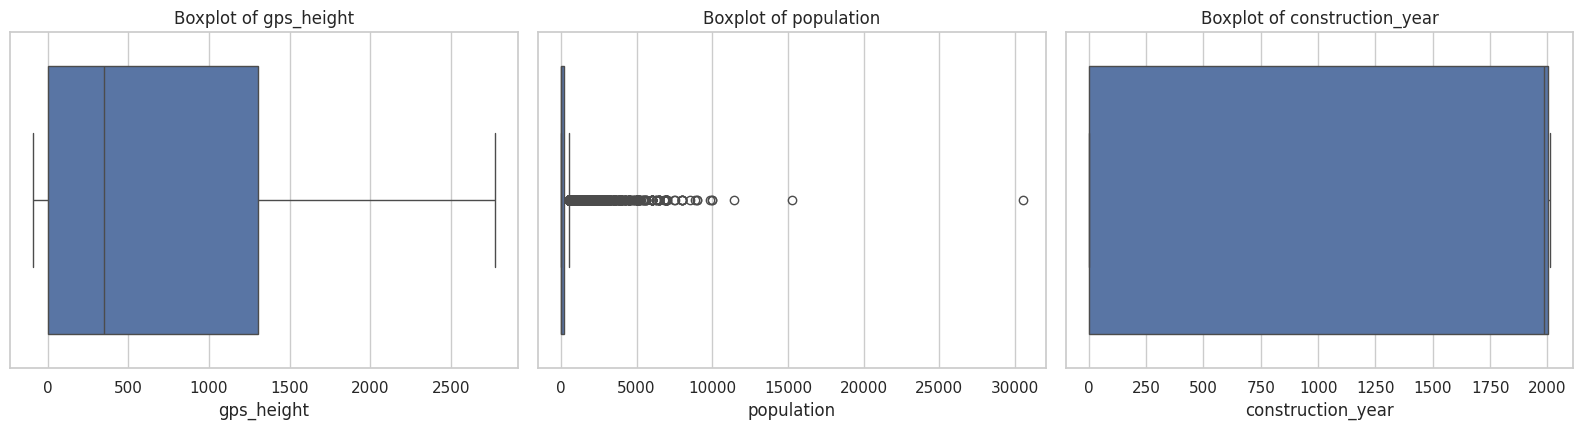

In [11]:
# Define numerical columns (excluding 'id')
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')

# Visualize outliers for selected numerical features using boxplots
plt.figure(figsize=(16, 8))
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [12]:
# Check unique values for `construction_year` feature
train_df['construction_year'].unique()

array([1999, 2010, 2009, 1986,    0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 2007, 1973, 1985, 1995, 2006,
       1962, 2005, 1997, 1970, 1996, 1977, 1983, 2012, 1984, 1982, 1976,
       1988, 1989, 1975, 1960, 1990, 1961, 1998, 1963, 1971, 1994, 1968,
       1980, 1993, 2001, 1979, 1967, 1969, 1981, 2013, 1964, 1966, 1965])

In [13]:
# Drop all row entries with a value of 0 in the column `construction_year`
train_df.drop(train_df[train_df['construction_year'] == 0].index, inplace=True)

In [14]:
# Recheck training dataset shape
train_df.shape
print(f"Training dataset consists of: {train_df.shape[0]} rows")
print(f"Training dataset consists of: {train_df.shape[1]} columns")

Training dataset consists of: 36764 rows
Training dataset consists of: 16 columns


In [15]:
# Feature Engineer a well_age variable
# Convert 'date_recorded' to datetime
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'], errors='coerce')

# Calculate well_age, but only where construction_year > 0 and not null
good_years = train_df['construction_year'].apply(lambda x: x > 0 and not pd.isnull(x))
train_df['well_age'] = np.where(good_years, train_df['date_recorded'].dt.year - train_df['construction_year'], np.nan)

# Ensure well_age is numeric
train_df['well_age'] = pd.to_numeric(train_df['well_age'], errors='coerce')

# Ensure 'construction_year' and 'date_recorded' are permanently removed from train_df
train_df = train_df.drop(columns=['construction_year', 'date_recorded'], errors='ignore')

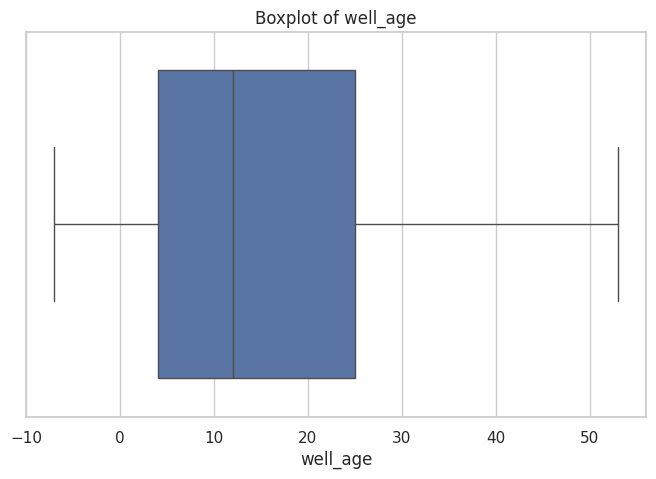

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=train_df['well_age'])
plt.title('Boxplot of well_age')
plt.xlabel('well_age')
plt.show()

In [17]:
# Add engineered feature to encoded DataFrame
train_df['well_age'] = train_df['well_age']
# Drop rows with missing well_age values due to left-skewed distribution
train_df = train_df.dropna(subset=['well_age'])

In [18]:
# Drop all row entries whose values are zero for the `population` feature
train_df.drop(train_df[train_df['population'] == 0].index, inplace=True)

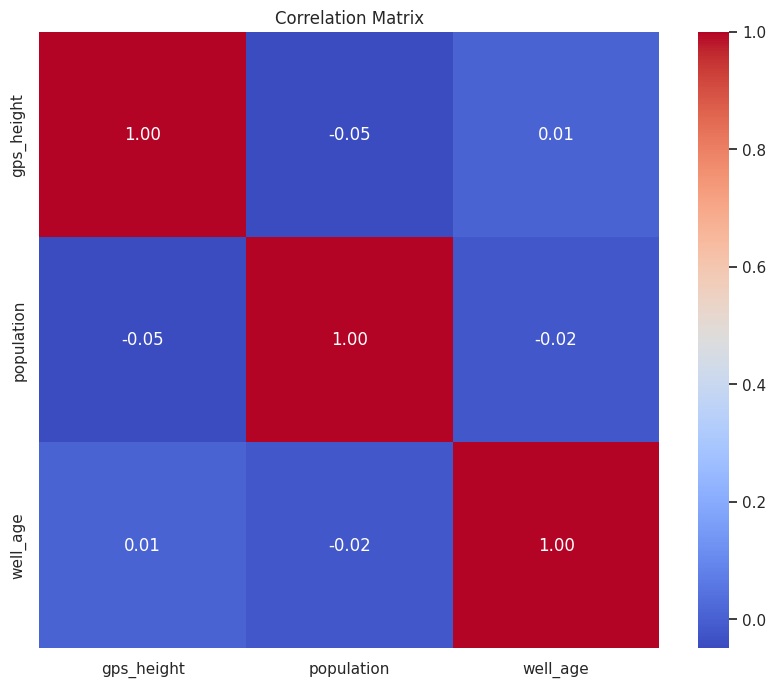

In [19]:
# Plot Correlation Matrix for numerical features
# Identify numerical columns
num_cols_1 = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_1.remove('id')

# Plot the correlation matrix
corr = train_df[num_cols_1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- The dataset contains both numerical and categorical features, with some missing values.
- Outliers present in numerical features `construction_year`, `gps_height`, and `population` were removed.
- Some features are highly skewed and may require transformation or scaling.
- The target variable is 'status_group', which is a ternary classification: 'functional', 'non functional', and 'functional needs repair'.

In [20]:
# Define categorical and numerical columns for training dataset
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('id')                                          

In [21]:
# Encode target variable and Feature Engineer it name
le = LabelEncoder()
train_df['status_group_encoded'] = le.fit_transform(train_df['status_group'])

In [22]:
# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_features = ohe.fit_transform(train_df[cat_cols])
cat_feature_names = ohe.get_feature_names_out(cat_cols)
cat_df = pd.DataFrame(cat_features, columns=cat_feature_names, index=train_df.index)

# Concatenate one-hot encoded features with the rest of the DataFrame
train_df_encoded = pd.concat([
    train_df.drop(columns=cat_cols),
    cat_df
], axis=1)

In [23]:
# # Scale numerical features
# scaler = StandardScaler()
# train_df_encoded[num_cols_1] = scaler.fit_transform(train_df_encoded[num_cols_1])

# # Remove outliers via the IQR formula
# for col in num_cols_1:
#     lower = train_df_encoded[col].quantile(0.25)
#     upper = train_df_encoded[col].quantile(0.75)
#     train_df_encoded[col] = np.clip(train_df_encoded[col], lower, upper)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical features using MinMaxScaler

scaler = MinMaxScaler()
train_df_encoded[num_cols_1] = scaler.fit_transform(train_df_encoded[num_cols_1])

# Remove outliers via the IQR formula
for col in num_cols_1:
    lower = train_df_encoded[col].quantile(0.25)
    upper = train_df_encoded[col].quantile(0.75)
    train_df_encoded[col] = np.clip(train_df_encoded[col], lower, upper)

In [25]:
# Recheck training dataset shape
train_df_encoded.shape
print(f"Training dataset consists of: {train_df_encoded.shape[0]} rows")
print(f"Training dataset consists of: {train_df_encoded.shape[1]} columns")

Training dataset consists of: 35420 rows
Training dataset consists of: 69 columns


In [26]:
train_df_encoded.head(10)

,id,gps_height,population,status_group,well_age,status_group_encoded,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,0.512884,0.003541,functional,0.316667,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,8776,0.516061,0.009148,functional,0.183333,0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,34310,0.264384,0.008164,functional,0.183333,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,67743,0.141546,0.001869,non functional,0.533333,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,9944,0.141546,0.001279,functional,0.183333,0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10,49056,0.141546,0.010500,functional,0.183333,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,50409,0.397106,0.008164,functional,0.533333,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13,50495,0.505118,0.001279,functional,0.183333,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
15,61848,0.533004,0.006525,functional,0.450000,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16,48451,0.533004,0.001279,non functional,0.533333,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35420 entries, 0 to 59399
Data columns (total 69 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   id                                        35420 non-null  int64  
 1   gps_height                                35420 non-null  float64
 2   population                                35420 non-null  float64
 3   status_group                              35420 non-null  object 
 4   well_age                                  35420 non-null  float64
 5   status_group_encoded                      35420 non-null  int64  
 6   basin_Lake Nyasa                          35420 non-null  float64
 7   basin_Lake Rukwa                          35420 non-null  float64
 8   basin_Lake Tanganyika                     35420 non-null  float64
 9   basin_Lake Victoria                       35420 non-null  float64
 10  basin_Pangani                          

In [28]:
# Recheck training dataset shape
train_df_encoded.shape
print(f"Training dataset consists of: {train_df_encoded.shape[0]} rows")
print(f"Training dataset consists of: {train_df_encoded.shape[1]} columns")

Training dataset consists of: 35420 rows
Training dataset consists of: 69 columns


In [29]:
# Split data into features and target
X = train_df_encoded.drop(['id', 'status_group', 'status_group_encoded'], axis=1)
y = train_df_encoded['status_group_encoded']

In [30]:
# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build and Evaluate Simple Model

Build a simple supervised classification model (Logistic Regression), evaluate its performance, and discuss its limitations. The simple model is tuned to re-evaluate performance before proceeding on to build alternative classification models.

In [31]:
# Build and Evaluate a Simple Model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Train simple model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
# Predict the target on the train set
y_pred_train = logreg.predict(X_train)
y_proba_train = logreg.predict_proba(X_train)

# Predict the target on the test set
y_pred_test = logreg.predict(X_test)
y_proba_test = logreg.predict_proba(X_test)

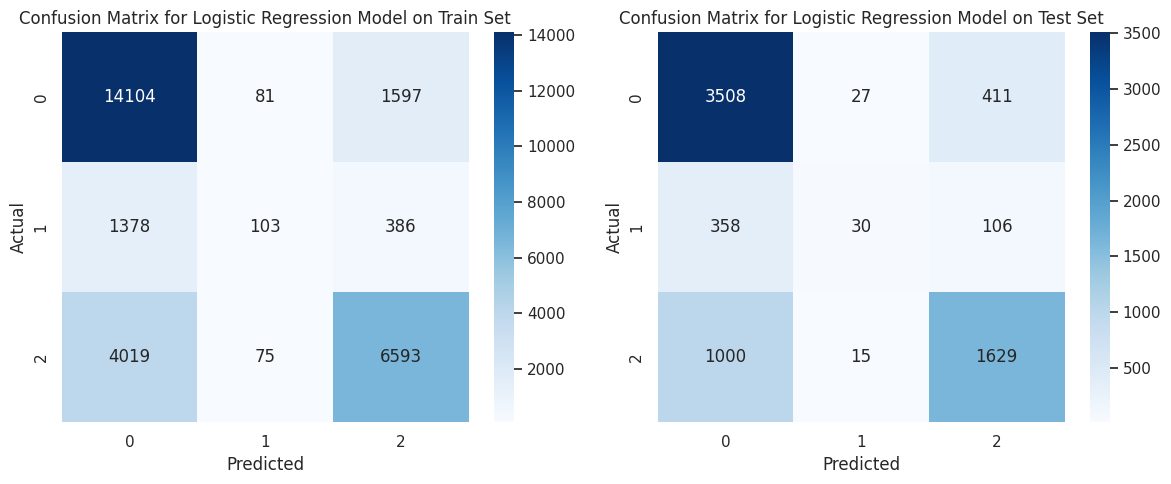

In [33]:
# Plot confusion matrices for logistic regression model on both train and test sets 
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Plot Confusion Matrix for model performance on train Set
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression Model on Train Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on test set
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Logistic Regression Model on Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [34]:
# Evaluate performance on train set
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, average='weighted')
rec_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')
roc_auc_train = roc_auc_score(y_train, y_proba_train, multi_class='ovr')

# Evaluate performance on test set
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='weighted')
rec_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')
roc_auc_test = roc_auc_score(y_test, y_proba_test, multi_class='ovr')

# Create a DataFrame with metrics for both train and test sets
import pandas as pd
metrics_df = pd.DataFrame({
    'Accuracy': [acc_train, acc_test],
    'Precision': [prec_train, prec_test],
    'Recall': [rec_train, rec_test],
    'F1-score': [f1_train, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_test]
}, index=['Logistic Regression model Performance on train set', 
          'Logistic Regression model Performance on test set'])
display(metrics_df)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Logistic Regression model Performance on train set,0.734049,0.718966,0.734049,0.709832,0.824985
Logistic Regression model Performance on test set,0.729390,0.713949,0.729390,0.704755,0.820124


Shape of y_train_bin: (28336, 3)
Shape of y_test_bin: (7084, 3)


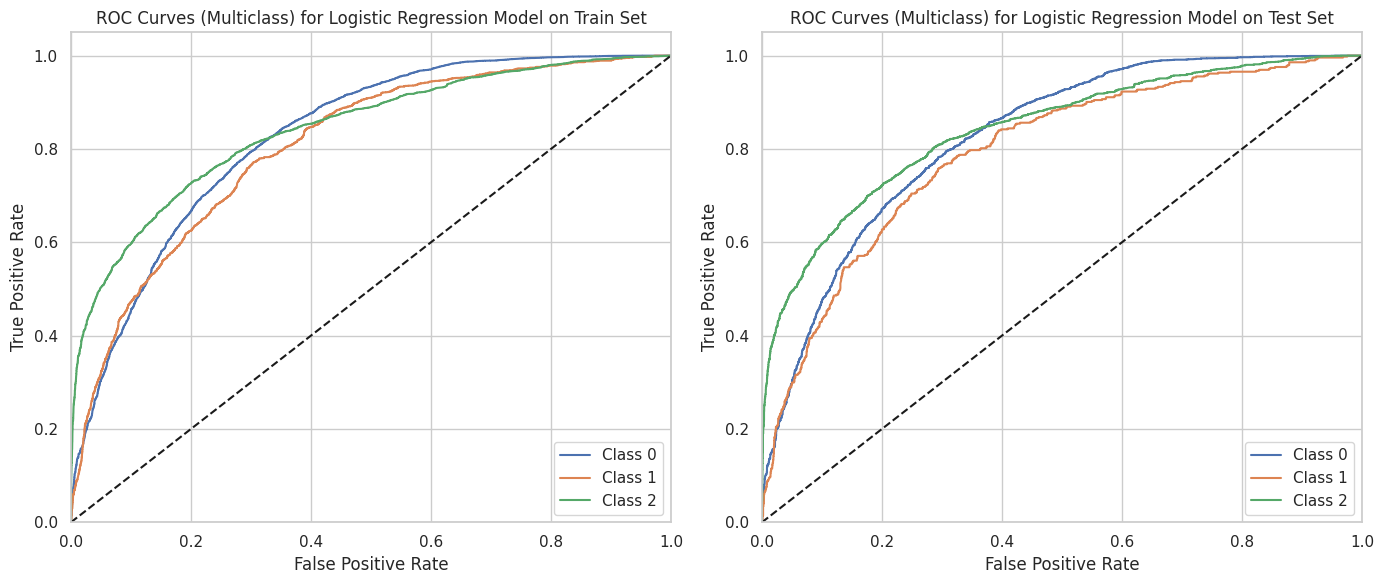

In [35]:
# Plot ROC curves for logistic regression model on both train and test sets
from sklearn.preprocessing import label_binarize

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize the true labels for each class
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

# Plot ROC curve for model performance on train set                            
y_train_bin = label_binarize(y_train, classes=range(n_classes))
print(f"Shape of y_train_bin: {y_train_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_train[:, i])
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--') 
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Multiclass) for Logistic Regression Model on Train Set')
axes[0].legend(loc='lower right')
axes[0].grid(True) 
axes[0].set_xlim([0.0, 1.0]) 
axes[0].set_ylim([0.0, 1.05]) 

# Plot  ROC curve for model performance on test set
# Binarize the true labels for each class
y_test_bin = label_binarize(y_test, classes=range(n_classes))
print(f"Shape of y_test_bin: {y_test_bin.shape}")

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--') 
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Multiclass) for Logistic Regression Model on Test Set')
axes[1].legend(loc='lower right') 
axes[1].grid(True) 
axes[1].set_xlim([0.0, 1.0]) 
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout() 
plt.show()

In [36]:
# Hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_train, y_train)
print(f"Best parameters: {gs.best_params_}")

# Predict on train and test sets
y_pred_gs_train = gs.predict(X_train)
y_proba_gs_train = gs.predict_proba(X_train)
y_pred_gs = gs.predict(X_test)
y_proba_gs = gs.predict_proba(X_test)

Best parameters: {'C': 100}


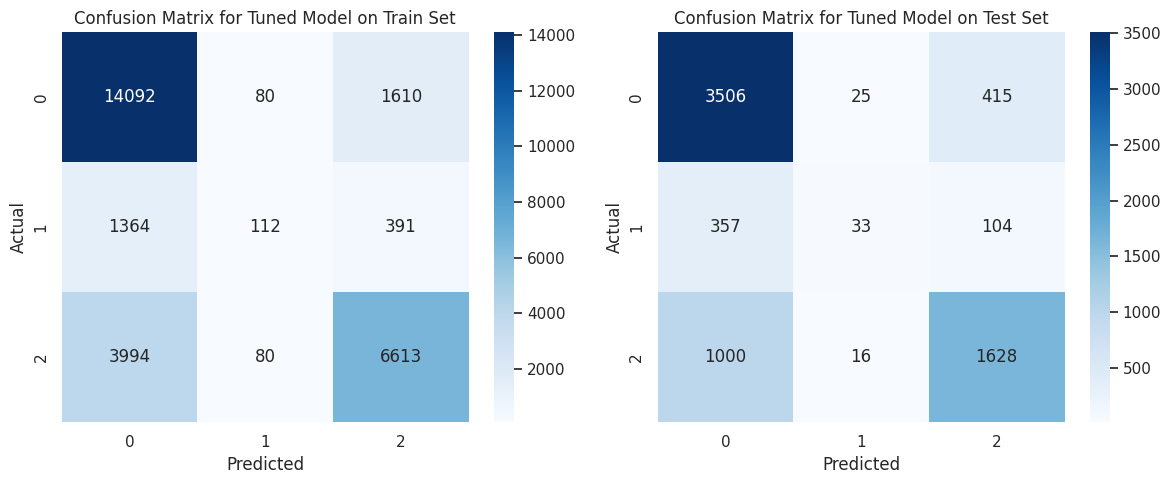

In [37]:
# Plot confusion matrices for logistic regression model performance on both train and test sets 
cm_test = confusion_matrix(y_test, y_pred_gs)
cm_train = confusion_matrix(y_train, y_pred_gs_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix for model performance on test set 
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix for Tuned Model on Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Plot Confusion Matrix for model performance on train set 
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix for Tuned Model on Train Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [44]:
# Evaluate performance on train set
acc_gs_train = accuracy_score(y_train, y_pred_gs_train)
prec_gs_train = precision_score(y_train, y_pred_gs_train, average='weighted')
rec_gs_train = recall_score(y_train, y_pred_gs_train, average='weighted')
f1_gs_train = f1_score(y_train, y_pred_gs_train, average='weighted')
roc_auc_gs_train = roc_auc_score(y_train, y_proba_gs_train, multi_class='ovr')

# Evaluate performance on test set
acc_gs = accuracy_score(y_test, y_pred_gs)
prec_gs = precision_score(y_test, y_pred_gs, average='weighted')
rec_gs = recall_score(y_test, y_pred_gs, average='weighted')
f1_gs = f1_score(y_test, y_pred_gs, average='weighted')
roc_auc_gs = roc_auc_score(y_test, y_proba_gs, multi_class='ovr')

# Create a DataFrame with metrics for both train and test sets
metrics_gs_df = pd.DataFrame({
    'Accuracy': [acc_gs_train, acc_gs],
    'Precision': [prec_gs_train, prec_gs],
    'Recall': [rec_gs_train, rec_gs],
    'F1-score': [f1_gs_train, f1_gs],
    'ROC-AUC': [roc_auc_gs_train, roc_auc_gs]
}, index=['Tuned Logistic Regression model Performance (train set)', 
          'Tuned Logistic Regression model Performance (test set)'])
display(metrics_gs_df)
print("-----------------------------------------------------------------------------------------------------------")

metrics_df = pd.DataFrame({
    'Accuracy': [acc_train, acc_test],
    'Precision': [prec_train, prec_test],
    'Recall': [rec_train, rec_test],
    'F1-score': [f1_train, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_test]
}, index=['Untuned Logistic Regression model performance (train set)', 
          'Untuned Logistic Regression model performance (test set)'])
display(metrics_df)


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Tuned Logistic Regression model Performance (train set),0.734649,0.720203,0.734649,0.710886,0.825344
Tuned Logistic Regression model Performance (test set),0.729390,0.715703,0.729390,0.705155,0.820636


-----------------------------------------------------------------------------------------------------------


,Accuracy,Precision,Recall,F1-score,ROC-AUC
Untuned Logistic Regression model performance (train set),0.734049,0.718966,0.734049,0.709832,0.824985
Untuned Logistic Regression model performance (test set),0.729390,0.713949,0.729390,0.704755,0.820124


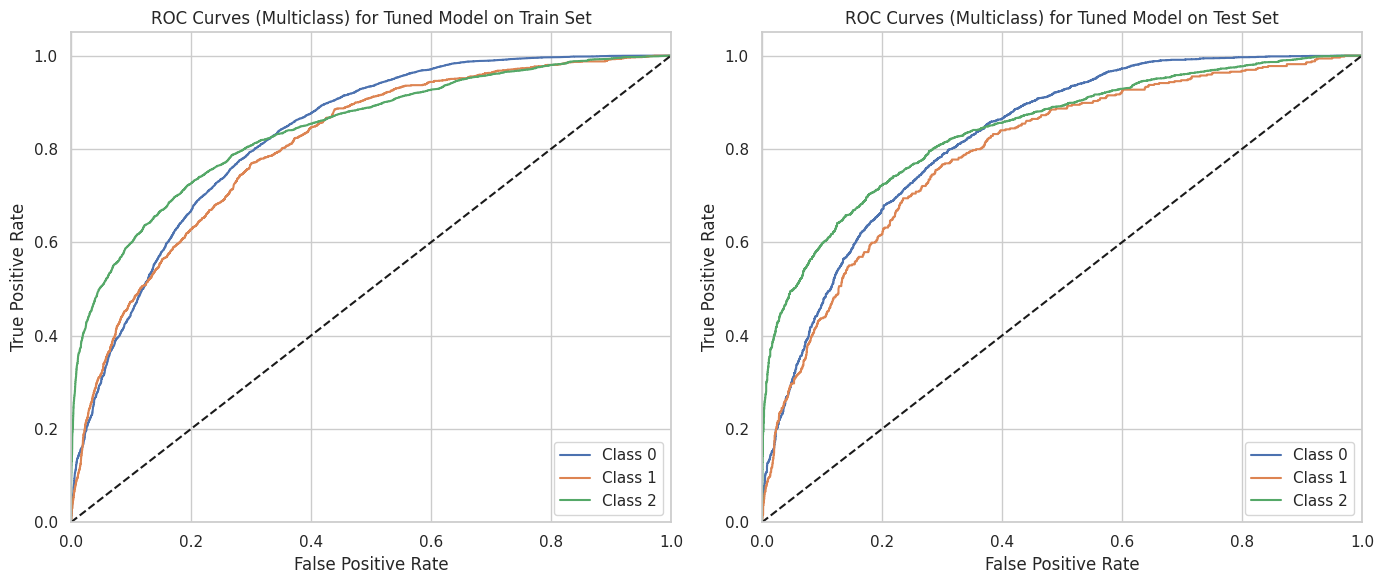

In [39]:
# Plot ROC curves for tuned logistic regression model on both train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Binarize y_test to match the structure needed by roc_curve for multiclass
all_labels = np.concatenate((y_train, y_test))
n_classes = len(np.unique(all_labels))

y_test_bin = label_binarize(y_test, classes=range(n_classes))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gs[:, i])
    axes[1].plot(fpr, tpr, label=f'Class {i}')

axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves (Multiclass) for Tuned Model on Test Set')
axes[1].legend(loc='lower right')
axes[1].grid(True)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])


# Binarize y_train to match the structure needed by roc_curve for multiclass
y_train_bin = label_binarize(y_train, classes=range(n_classes)) 
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_proba_gs_train[:, i]) 
    axes[0].plot(fpr, tpr, label=f'Class {i}')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (Multiclass) for Tuned Model on Train Set') 
axes[0].legend(loc='lower right')
axes[0].grid(True)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()